Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from statistics import mean
from sklearn.metrics import accuracy_score, mean_squared_error

Data import

In [2]:
df = pd.read_csv('data/processed/EDA.csv', usecols=['ID','INTERPRET', 'TITEL', 'TEXT', 'processed_TEXT','POSITION','DATUM_VON', 'DATUM_BIS', 'DAUER', 'JAHR', 'MONAT', 'ANZ_UNIQUE_WOERTER', 'LAENGE_LAENGSTES_WORT', 'RANK_SCORE', 'NUMBER_OF_STOPWORDS', 'STOPWORD_PERCENTAGE', 'SUBJECTIVITY', 'POLARITY', 'processed_TITLE'])
print(df.columns)

Index(['ID', 'INTERPRET', 'TITEL', 'TEXT', 'processed_TEXT', 'POSITION',
       'DATUM_VON', 'DATUM_BIS', 'DAUER', 'JAHR', 'MONAT',
       'ANZ_UNIQUE_WOERTER', 'LAENGE_LAENGSTES_WORT', 'RANK_SCORE',
       'NUMBER_OF_STOPWORDS', 'STOPWORD_PERCENTAGE', 'SUBJECTIVITY',
       'POLARITY', 'processed_TITLE'],
      dtype='object')


In [4]:
df

,ID,INTERPRET,TITEL,TEXT,processed_TEXT,POSITION,DATUM_VON,DATUM_BIS,DAUER,JAHR,MONAT,ANZ_UNIQUE_WOERTER,LAENGE_LAENGSTES_WORT,NUMBER_OF_STOPWORDS,STOPWORD_PERCENTAGE,SUBJECTIVITY,POLARITY,processed_TITLE,RANK_SCORE
0,408,Rumpelstilz,Kiosk,ALSO ER SAMMLE FUER EINEN GUTEN ZWECK SAGT DE...,"['ALSO', 'SAMML', 'FUER', 'GUT', 'ZWECK', 'SAG...",50,2009-03-06,2009-03-12,6,2009,3,83,13,48,0.00211,0.400000,0.100000,['KIOSK'],24
1,408,Rumpelstilz,Kiosk,ALSO ER SAMMLE FUER EINEN GUTEN ZWECK SAGT DE...,"['ALSO', 'SAMML', 'FUER', 'GUT', 'ZWECK', 'SAG...",4,1984-10-22,1984-10-28,6,1984,10,83,13,48,0.00211,0.400000,0.100000,['KIOSK'],24
2,425,Costa Cordalis,Anita,JVUIOUGIVTOH ICH FAND SIE IRGENDWO ALLEIN IN ...,"['JVUIOUGIVTOH', 'FAND', 'IRGENDWO', 'ALLEIN',...",23,2003-08-25,2003-08-31,6,2003,8,73,12,43,0.00189,0.000000,0.000000,['ANITA'],27
3,425,Costa Cordalis,Anita,JVUIOUGIVTOH ICH FAND SIE IRGENDWO ALLEIN IN ...,"['JVUIOUGIVTOH', 'FAND', 'IRGENDWO', 'ALLEIN',...",39,2003-07-28,2003-08-03,6,2003,8,73,12,43,0.00189,0.000000,0.000000,['ANITA'],27
4,425,Costa Cordalis,Anita,JVUIOUGIVTOH ICH FAND SIE IRGENDWO ALLEIN IN ...,"['JVUIOUGIVTOH', 'FAND', 'IRGENDWO', 'ALLEIN',...",27,2003-07-28,2003-08-03,6,2003,8,73,12,43,0.00189,0.000000,0.000000,['ANITA'],27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22757,2303823,AnnenMayKantereit,3 Tage am Meer,ICH WEISS WAS ICH KANN TROTZDEM AB UND AN KOM...,"['WEISS', 'KANN', 'TROTZD', 'KOMM', 'EN', 'ZWE...",21,1980-11-24,1980-11-30,6,1980,11,45,11,26,0.00114,0.000000,0.000000,"['', 'TAG', 'MEER']",30
22758,2304169,Farid Bang & B-Case,Baller,BALLER LA LA LA ICH ZIEH DIE WAFFE UND ICH...,"['BALL', 'LA', 'LA', 'LA', 'ZIEH', 'WAFF', 'BA...",42,2020-04-10,2020-04-16,6,2020,4,149,14,60,0.00264,0.525000,0.045833,['BALL'],9
22759,2304914,Yung Hurn,Alleine,BABY SAG MIR WAS DU HEUTE MACHST HAST DU ZEI...,"['BABY', 'SAG', 'HEUT', 'MACH', 'JA', 'BABY', ...",20,2019-10-18,2019-10-24,6,2019,10,58,7,42,0.00185,0.600000,0.600000,['ALLEIN'],31
22760,2304939,Azet & Zuna,Ohh oh,OH OH AH OH ULTRA PLUS BABY BIN MEIN ...,"['OH', 'OH', 'AH', 'OH', 'ULTRA', 'BABY', 'EIG...",5,2019-07-26,2019-08-01,6,2019,8,109,13,51,0.00224,0.616667,-0.216667,"['OHH', 'OH']",46


Train-Test Split

In [6]:
df_test = df.loc[df['JAHR'] == 2022]
df_train = df.loc[df['JAHR'] < 2022]
X_test = df_test[['JAHR', 'ANZ_UNIQUE_WOERTER', 'NUMBER_OF_STOPWORDS', 'STOPWORD_PERCENTAGE', 'SUBJECTIVITY']]
y_test = df_test['RANK_SCORE']

X_train = df_train[['JAHR', 'ANZ_UNIQUE_WOERTER', 'NUMBER_OF_STOPWORDS', 'STOPWORD_PERCENTAGE', 'SUBJECTIVITY']]
y_train = df_train['RANK_SCORE']
print(np.shape(X_train))
print(np.shape(X_test))

#X_train, X_test, y_train, y_test = train_test_split(df['DAUER'], df.RANK_SCORE, test_size=0.5, stratify=df.RANK_SCORE, random_state=123456)

(22056, 5)
(706, 5)


Modelling

AxesSubplot(0.125,0.11;0.775x0.77)


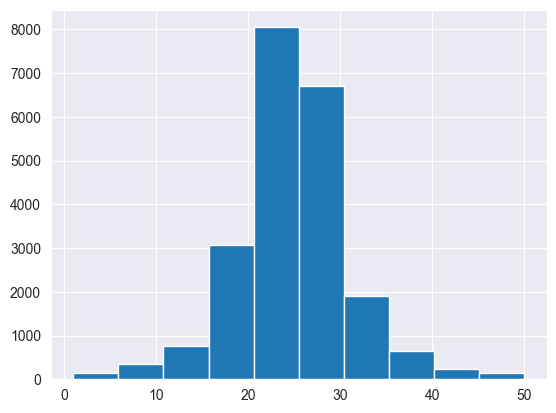

In [7]:
print(y_train.hist())

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=123450, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=123450)

In [10]:
ypred = rf.predict(X_test)
accuracy_score(y_test,ypred)
#mean_squared_error(y_test, ypred)

0.3286118980169972

In [11]:
score = rf.score(X_train, y_train)
ypred = rf.predict(X_test)
mse = mean_squared_error(y_test, ypred)

print(score)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))
print(np.shape(ypred))
print(np.shape(y_test))
df_ = pd.DataFrame()
df_["y_test"] = y_test
df_["y_pred"] = ypred
print(df_.head())

0.9986398258977149
MSE:  159.5
RMSE:  79.75
(706,)
(706,)
     y_test  y_pred
124      26      26
125      26      26
127      26      26
128      26      26
129      26      26


In [85]:
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
mse = mean_squared_error(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(f'Mean Squared Error: {mse:.13}')

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [17]:
scaler = MinMaxScaler()
data = [[index, ypred[index]] for index in range(1,len(ypred))]
print(scaler.fit(data))
print(scaler.data_max_)
print(scaler.transform(data))

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train)

MinMaxScaler()
[705.  49.]
[[0.         0.52083333]
 [0.00142045 0.52083333]
 [0.00284091 0.52083333]
 ...
 [0.99715909 0.95833333]
 [0.99857955 0.64583333]
 [1.         0.14583333]]


In [63]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=df.RANK_SCORE, index=df.RANK_SCORE)
sns.heatmap(cm, annot=True)

ValueError: Shape of passed values is (50, 50), indices imply (22762, 22762)

In [ ]:
df.RANK_SCORE